# Machine Learning Layer
#### Goal: Estimate the next beta

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

import pickle
import joblib

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [56]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v3.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [57]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
30935,11,57.440000,Other,-1.857143,15.671429,7.557143,1.132653,1.820088e-22,2.207629e-01,2020-06-01,Rhein-Sieg-Kreis
30934,10,57.780000,Other,-6.714286,15.714286,8.885714,2.612245,1.519930e-20,4.148546e-01,2020-05-25,Rhein-Sieg-Kreis
23224,8,64.330000,Other,-22.428571,13.014286,8.528571,0.326531,8.864302e-20,2.854948e-02,2020-05-11,"Ansbach, Stadt"
18711,7,69.342857,Other,-19.428571,11.814286,7.542857,1.857143,1.457825e-18,4.575471e-01,2020-05-04,Oberhavel
29896,6,65.180000,Other,-22.428571,13.314286,12.971429,4.714286,5.088751e-18,5.191965e-01,2020-04-27,Essen
...,...,...,...,...,...,...,...,...,...,...,...
30377,17,58.804286,Other,9.285714,13.657143,13.928571,0.744898,3.911611e+00,5.671122e-07,2020-07-13,"Schwerin, Landeshauptstadt"
7963,69,73.210000,B.1.617.2,17.000000,17.714286,7.914286,0.663265,4.153034e+00,4.618029e-07,2021-07-12,Regen
17968,16,63.390000,Other,-6.000000,19.671429,NaN,1.959184,4.243599e+00,5.866944e-07,2020-07-06,Main-Tauber-Kreis
24643,17,58.804286,Other,-4.714286,13.414286,NaN,2.030612,4.253974e+00,5.615672e-07,2020-07-13,"Hof, Kreis"


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

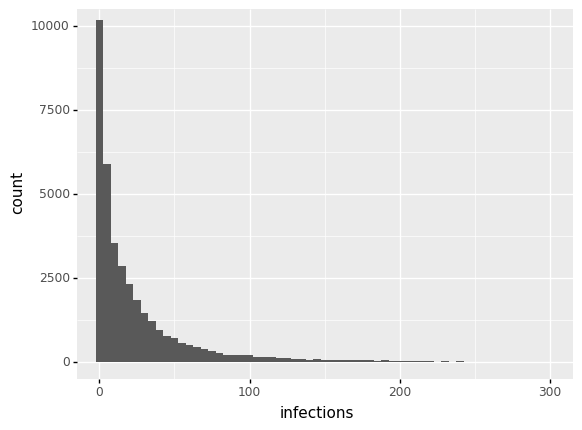

<ggplot: (387675977)>

In [64]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,300),ylim=(0,10000))

#### 2.2) Fitted beta:

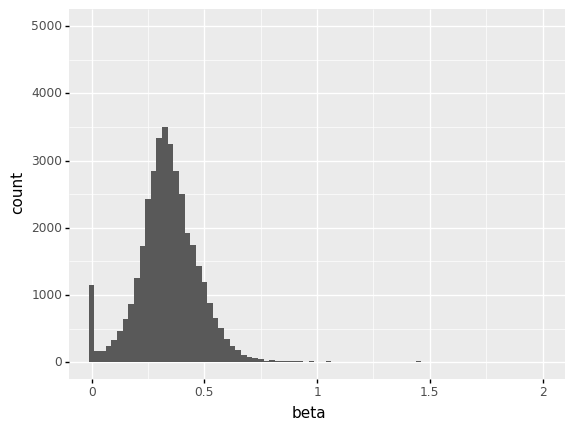

<ggplot: (383984436)>

In [59]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

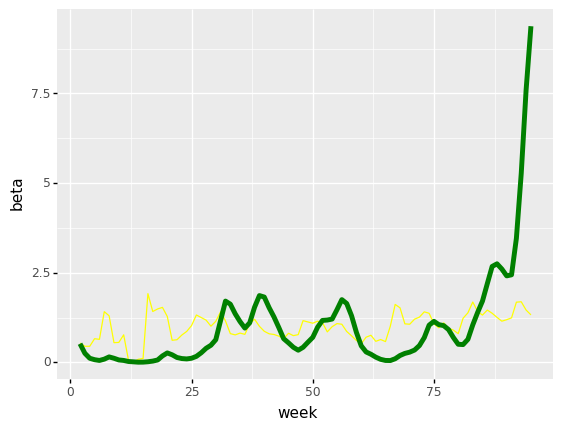

<ggplot: (386994195)>

In [60]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

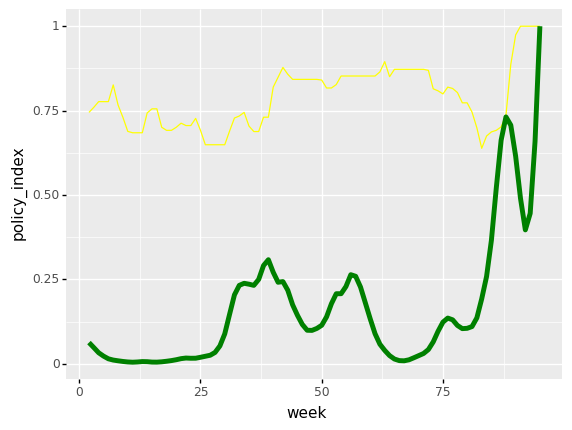

<ggplot: (384392226)>

In [61]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [62]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [63]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

-0.05740198589413011

## 4) Data cleaning:
#### Identify missing values:

In [10]:
df.isnull().sum()

week                        0
policy_index                0
variant                     0
mobility                    0
temperature                11
wind                      142
infections                  0
beta                        0
beta_t_minus_1              0
start_date_forecasting      0
district                    0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [11]:
df_v4 = df.copy()

In [12]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_4319/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_4319/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [13]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
9618,2,71.55,Other,-11.857143,7.671429,11.512403,93.663265,0.349003,0.331900,2021-03-30,Aachen
9619,3,71.55,Other,-13.000000,10.642857,11.814286,106.346939,0.360983,0.346730,2021-04-06,Aachen
9620,4,71.55,Other,-25.857143,4.257143,14.671429,128.040816,0.375566,0.363328,2021-04-13,Aachen
9621,5,71.55,Other,-16.285714,4.557143,9.700000,134.081633,0.340415,0.366001,2021-04-20,Aachen
9622,6,71.55,Other,-10.285714,7.900000,11.242857,116.173469,0.281417,0.366969,2021-04-27,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
1213,39,83.93,Other,-2.571429,0.428571,8.528571,288.051020,0.314815,0.356433,2021-12-14,Zwickau
1214,40,83.93,Other,-1.000000,4.842857,10.485714,190.163265,0.289680,0.344801,2021-12-21,Zwickau
1215,41,83.93,B.1.1.7,-4.285714,-1.200000,10.700000,138.704082,0.341600,0.278017,2021-12-28,Zwickau
1216,42,83.93,Other,-15.714286,7.871429,16.885714,102.959184,0.326322,0.342802,2022-01-04,Zwickau


## 5) Outlier removal:


In [14]:
# Identify outliers:

In [15]:
df_v4[df_v4['infections'] > 20].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
6381,41,83.930000,B.1.1.7,-12.714286,2.557143,7.571429,235.897959,0.285985,0.147739,2021-12-28,Stuttgart
8733,41,83.930000,B.1.1.7,-8.571429,0.857143,6.771429,22.520408,0.284046,0.159157,2021-12-28,"Rosenheim, Stadt"
1593,41,83.930000,B.1.1.7,-6.571429,-1.671429,11.300000,23.000000,0.725966,0.167172,2021-12-28,Wilhelmshaven
9627,11,75.120000,Other,-10.000000,11.742857,15.800000,20.367347,0.217665,0.172679,2021-06-01,Aachen
15536,40,83.930000,Other,14.142857,0.685714,5.200000,20.438776,0.304839,0.173311,2021-12-21,Straubing-Bogen
...,...,...,...,...,...,...,...,...,...,...,...
2938,42,83.930000,Other,-10.142857,5.471429,19.714286,225.867347,0.405923,0.812429,2022-01-04,Rendsburg-Eckernförde
2260,36,61.780000,Other,19.857143,3.814286,14.957143,285.744898,0.437373,0.820917,2021-11-23,Harz
10659,35,58.890000,Other,-9.571429,8.185714,11.014286,24.255102,0.455292,0.830586,2021-11-16,"Neumünster, Stadt"
15035,43,83.930000,Other,1.000000,3.157143,11.157143,314.346939,0.392601,0.842865,2022-01-11,"Lübeck, Hansestadt"


#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [68]:
# Drop all rows in which average number of infections is below 5:
threshold = 20
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [69]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

In [70]:
# correlation:
df_v5_2['beta'].corr(df_v5_2['beta_t_minus_1'] )

0.47702376630604376

## 6) Preprocessing columns:


#### 6.1) Handling categorical columns:

In [18]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [19]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [20]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

#### 6.2) Standardizing:

In [21]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_d.drop(columns=['beta'], axis=1)
beta_cols = df_v6_2_d[['beta']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)

## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [22]:
df_full = df_v6_3
df_full

,,,B.1.1.7,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,
2,Aachen,2021-03-30,-0.195391,0.159649,-0.889214,-0.153346,0.034214,0.172603,-0.673669,0.349003
3,Aachen,2021-04-06,-0.195391,0.159649,-0.972320,0.407433,0.114824,0.265113,-0.526146,0.360983
4,Aachen,2021-04-13,-0.195391,0.159649,-1.907262,-0.797702,0.877744,0.423340,-0.361037,0.375566
5,Aachen,2021-04-20,-0.195391,0.159649,-1.211250,-0.741085,-0.449738,0.467399,-0.334448,0.340415
6,Aachen,2021-04-27,-0.195391,0.159649,-0.774943,-0.110209,-0.037761,0.336784,-0.324817,0.281417
...,...,...,...,...,...,...,...,...,...,...
39,Zwickau,2021-12-14,-0.195391,1.526795,-0.213978,-1.520245,-0.762535,1.590392,-0.429622,0.314815
40,Zwickau,2021-12-21,-0.195391,1.526795,-0.099707,-0.687164,-0.239934,0.876437,-0.545336,0.289680
41,Zwickau,2021-12-28,5.117955,1.526795,-0.338637,-1.827595,-0.182715,0.501113,-1.209676,0.341600


In [23]:
# Sample 1500 row out of last weeks available for training:
sample_size = 1500
max_week = max(df_full.index.get_level_values('week'))

random_indices = df_full[df_full.index.get_level_values('week') >= max_week-5].sample(sample_size).index

In [24]:
df_modeling = df_full.loc[df_full.index.isin(random_indices)]
df_test = df_full.loc[~df_full.index.isin(random_indices)]

#### 7.1.2) Split into train, val and test:

In [25]:
SEED = 420

In [26]:
X_full_modeling = df_modeling.drop(columns=['beta'], axis=1)
y_full_modeling = df_modeling['beta']

X_test = df_test.drop(columns=['beta'], axis=1)
y_test = df_test['beta']

In [27]:
# Train and Val:
X_train, X_val, y_train, y_val = train_test_split(X_full_modeling, y_full_modeling, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [28]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:

# As the values are standardized we have to reverse standardize them first:
y_pred_baseline_val = pd.DataFrame(scaler_obj.inverse_transform(X_val), index=X_val.index, columns=X_val.columns)['beta_t_minus_1']

In [29]:
# Correlation of this approach:
y_pred_baseline_val.corr(y_val)

0.35302575474847586

In [30]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline_val})

y_val  y_pred_baseline
week district         start_date_forecasting                           
39   Göppingen        2021-12-14              0.289423         0.323902
38   Emsland          2021-12-07              0.350613         0.412481
41   Ingolstadt       2021-12-28              0.514992         0.345586
40   Düren            2021-12-21              0.373025         0.291899
41   Karlsruhe, Kreis 2021-12-28              0.494699         0.312325
...                                                ...              ...
40   Kassel           2021-12-21              0.358914         0.380889
     Coburg, Kreis    2021-12-21              0.257045         0.442927
38   Stade            2021-12-07              0.436826         0.347918
39   Bergstraße       2021-12-14              0.329667         0.382855
     Ostalbkreis      2021-12-14              0.310357         0.292832

[375 rows x 2 columns]

In [31]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline_val, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.11955502151910251


#### 7.2.2) Multivariate Linear Regression

In [32]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [33]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.07646011555010737. This is an improvement compared to the baseline approach of: 36.04608607937847 %


#### 7.2.3) Ridge Regression:

In [34]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [35]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.07644144115218485. This is an improvement compared to the baseline approach of: 36.06170599871371 %


#### 7.2.4) Random Forest Regressor:

In [36]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [37]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.07462924278353295. This is an improvement compared to the baseline approach of: 37.57749207413368 %


#### 7.2.5) Support Vector Machines

In [38]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [39]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.07399607761339361. This is an improvement compared to the baseline approach of: 38.10709355978786 %


#### 7.2.6) XGBoost

In [40]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [41]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.08085738511991428. This is an improvement compared to the baseline approach of: 32.36805606948523 %


In [42]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline_val, 'last_beta_standardized':X_val['beta_t_minus_1'], 'xgb_bred':y_pred_xgb}).sort_values('start_date_forecasting', ascending=False)

beta_opt  last_beta  \
week district          start_date_forecasting                        
43   Steinfurt         2022-01-11              0.476135   0.523729   
     Münster           2022-01-11              0.459019   0.527024   
     Ostallgäu         2022-01-11              0.490584   0.520880   
     Wetterau          2022-01-11              0.555836   0.472425   
     Osterholz         2022-01-11              0.412214   0.494610   
...                                                 ...        ...   
38   Landshut, Kreis   2021-12-07              0.335774   0.337443   
     Regen             2021-12-07              0.352470   0.347833   
     Regensburg, Kreis 2021-12-07              0.331007   0.336154   
     Augsburg, Stadt   2021-12-07              0.306548   0.375301   
     Erfurt            2021-12-07              0.474674   0.468698   

                                               last_beta_standardized  \
week district          start_date_forecasting                           
43   Steinfurt         2022-01-11                            1.234576   
     Münster           2022-01-11                            1.267350   
     Ostallgäu         2022-01-11                            1.206234   
     Wetterau          2022-01-11                            0.724221   
     Osterholz         2022-01-11                            0.944906   
...                                                               ...   
38   Landshut, Kreis   2021-12-07                           -0.618523   
     Regen             2021-12-07                           -0.515172   
     Regensburg, Kreis 2021-12-07                           -0.631351   
     Augsburg, Stadt   2021-12-07                           -0.241936   
     Erfurt            2021-12-07                            0.687142   

                                               xgb_bred  
week district          start_date_forecasting            
43   Steinfurt         2022-01-11              0.519797  
     Münster           2022-01-11              0.455775  
     Ostallgäu         2022-01-11              0.571781  
     Wetterau          2022-01-11              0.513563  
     Osterholz         2022-01-11              0.513412  
...                                                 ...  
38   Landshut, Kreis   2021-12-07              0.384310  
     Regen             2021-12-07              0.322432  
     Regensburg, Kreis 2021-12-07              0.411157  
     Augsburg, Stadt   2021-12-07              0.370339  
     Erfurt            2021-12-07              0.390823  

[375 rows x 4 columns]

#### 7.2.7) Neural Network

In [43]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

2022-01-28 12:15:08.085894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
36/36 [==============================] - 1s 5ms/step - loss: 1.5173 - rmse: 1.2318 - val_loss: 0.2311 - val_rmse: 0.4807
Epoch 2/20
36/36 [==============================] - 0s 2ms/step - loss: 0.3034 - rmse: 0.5508 - val_loss: 0.0303 - val_rmse: 0.1741
Epoch 3/20
36/36 [==============================] - 0s 2ms/step - loss: 0.5461 - rmse: 0.7390 - val_loss: 0.0204 - val_rmse: 0.1428
Epoch 4/20
36/36 [==============================] - 0s 2ms/step - loss: 0.1425 - rmse: 0.3775 - val_loss: 0.0164 - val_rmse: 0.1281
Epoch 5/20
36/36 [==============================] - 0s 2ms/step - loss: 0.1475 - rmse: 0.3841 - val_loss: 0.0150 - val_rmse: 0.1223
Epoch 6/20
36/36 [==============================] - 0s 2ms/step - loss: 0.1357 - rmse: 0.3684 - val_loss: 0.0141 - val_rmse: 0.1189
Epoch 7/20
36/36 [==============================] - 0s 2ms/step - loss: 0.1057 - rmse: 0.3251 - val_loss: 0.0135 - val_rmse: 0.1162
Epoch 8/20
36/36 [==============================] - 0s 2ms/step - loss: 0.06

In [45]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [46]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x16e82c280> is: 0.10378449036571803. This is an improvement compared to the baseline approach of: 13.191023641666666 %


## 8) Model Evaluation:

### Metric Computation:

In [47]:
y_pred_baseline_test = pd.DataFrame(scaler_obj.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)['beta_t_minus_1']
rmse_baseline_test = mean_squared_error(y_pred_baseline_test, y_test, squared=False)
print(f'RMSE of baseline approach is: {rmse_baseline_test}')

RMSE of baseline approach is: 0.10102208552586288


In [48]:
# Apply optimal model to testset:
y_pred_test_xgb = xgb_model.predict(X_test)

rmse_xgb_test = mean_squared_error(y_pred_test_xgb, y_test, squared=False)
print(f'RMSE of {xgb_model} is: {rmse_xgb_test}. This is an improvement compared to the baseline approach of: {-(rmse_xgb_test / rmse_baseline_test -1)*100} %')

RMSE of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0) is: 0.11594101104418278. This is an improvement compared to the baseline approach of: -14.767984090469488 %


### Model comparison:

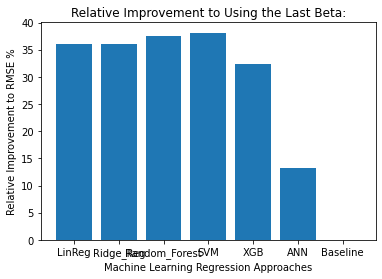

In [53]:
rmses_dict = {
    'LinReg': rmse_linreg,
    'Ridge_Reg': rmse_ridge_reg,
    'Random_Forest': rmse_random_forest,
    'SVM': rmse_svm,
    'XGB': rmse_xgb,
    'ANN':rmse_ann,
    'Baseline': rmse_baseline,
}

rmses_rel_improvement = {k:(-(v/rmse_baseline-1)*100) for (k,v) in rmses_dict.items()}
rmses_rel_improvement

plt.bar(x=rmses_rel_improvement.keys(),height=rmses_rel_improvement.values())
plt.title("Relative Improvement to Using the Last Beta:")
plt.xlabel(xlabel='Machine Learning Regression Approaches')
plt.ylabel(ylabel='Relative Improvement to RMSE %')
plt.show()

### Feature Importance:

<AxesSubplot:>

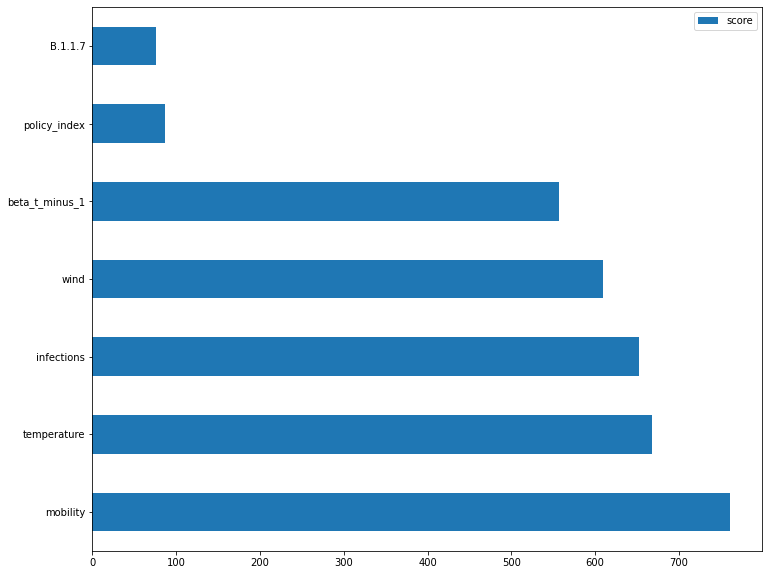

In [54]:
feature_important = xgb_model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (12,10)) ## plot top 40 features

## 9) Export Best Model:

In [51]:
path = '../../../../Assets/MachineLearningLayer/Models/'
best_model = xgb_model

# ML Model:
filename = 'xgb_model_lukas.pkl'
combined_path = path+filename
joblib.dump(best_model, open(combined_path, 'wb'))

# Standardizer:
filename = 'standardizer_model.pkl'
combined_path = path+filename
joblib.dump(scaler_obj, open(path+filename, 'wb'))